# Baseline for datasets

In [1]:
from CNN.config import Config
from CNN.utils import WordEmbeddingLoader, RelationLoader, SemEvalDataLoader
import numpy as np
config = Config()
config.batch_size = 1
config.embedding_path = "./CNN/embedding/hlbl-embeddings-scaled.EMBEDDING_SIZE=50.txt"
config.data_dir = "./CNN/data/simeval2010/"  # change the dataset here
word2id, word_vec = WordEmbeddingLoader(config).load_embedding()
rel2id, id2rel, class_num = RelationLoader(config).get_relation()
loader = SemEvalDataLoader(rel2id, word2id, config)

/home/dmitrii/anaconda3/envs/psdaub4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get X and y vectors from dataset
NB: X is already a feature vector got from the word embedding

In [2]:
def get_x_y_from_loader(loader):
    # upload train and test from dataloader
    X = []
    y = []
    for step, (data, label) in enumerate(loader):
        x = data.detach().numpy().flatten()
        x.astype(int)
        X.append(x)
        y.append(label.detach().numpy()[0])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = get_x_y_from_loader(loader.get_train())
X_test, y_test = get_x_y_from_loader(loader.get_test())

## Metrics
According to the [survey](https://link.springer.com/content/pdf/10.1007/s10115-022-01665-w.pdf), the main metrics are Accuracy, Precision, Recall and F1 Score. However, they may generate overoptimistic, misleading results on
imbalanced datasets, as they failed to consider the ratio between positive and negative classes. To mitigate this, Matthews Correlation Coefficient (It is high only when the classifier is doing well in both positive and negative
classes) and G-Mean-Score (a poor performance in positive examples prediction will lead to a low G-mean
value, even if negative instances are correctly classified by the classifier) are used.

In [3]:
from custom_statistics import Statistics
stats = Statistics()
random_states = [0, 1, 42, 100, 5782]

## Baseline: Bayessian Classifier
According to the [survey](https://link.springer.com/content/pdf/10.1007/s10115-022-01665-w.pdf), different baselines are possible. For instance, Logistic Regression, Decision Trees, SVM. [Sorgente et al.](http://ceur-ws.org/Vol-1109/paper4.pdf) used Naive Bayes.

### Naive Bayes

In [4]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
predictions_nb = nb.predict(X_test)
re_nb = stats.get_metrics(predictions_nb, y_test, show=True)

Accuracy Score ->  0.3813029076186971
Precision Score ->  0.7800360837739175
Recall Score ->  0.3813029076186971
F1 Score ->  0.4874455624889103
Matthews Correlation Coefficient ->  0.010199865830754223
G Mean Score ->  0.3518476211430939


#### with train_test_split

In [5]:
from sklearn.model_selection import train_test_split

# train_test_split(X_train, y_train, test_size=0.5, random_state=0, shuffle=False)  for dataset simeval2010
# train_test_split(X_train, y_train, test_size=0.4, random_state=3) for dataset simeval2007
XX_train, XX_test, yy_train, yy_test = train_test_split(X_train, y_train, test_size=0.5, random_state=0, shuffle=False) 
nb.fit(XX_train, yy_train)
predictions_nb_split = nb.predict(X_test)
re_nb_split = stats.get_metrics(predictions_nb_split, y_test, show=True)

Accuracy Score ->  0.41001104158998897
Precision Score ->  0.7801453541099056
Recall Score ->  0.41001104158998897
F1 Score ->  0.5156699423987103
Matthews Correlation Coefficient ->  0.009825948592028629
G Mean Score ->  0.3507180494934826


#### with RepeatedKFold

In [6]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=3)
for train, test in rkf.split(X_train):
    Xx_train, Xx_test = X_train[train], X_train[test]
    Yy_train, Yy_test = y_train[train], y_train[test]
    nb_kf = nb.fit(Xx_train, Yy_train)
predictions_nb_kf = nb_kf.predict(X_test)
re_nb_kf = stats.get_metrics(predictions_nb_kf, y_test, show=True) 

Accuracy Score ->  0.3702613176297387
Precision Score ->  0.7829896147430058
Recall Score ->  0.3702613176297387
F1 Score ->  0.4773051801868002
Matthews Correlation Coefficient ->  0.01197705235775481
G Mean Score ->  0.34805434475766883


## Other possible baselines
### Logistic Regression

In [7]:
import warnings

warnings.filterwarnings('ignore')

stats.clean()
from sklearn.linear_model import LogisticRegression
for random_state in random_states:
    logreg = LogisticRegression(solver='lbfgs', random_state=random_state, multi_class='multinomial', max_iter=100, n_jobs=16)
    logreg.fit(X_train, y_train)
    predictions_logreg = logreg.predict(X_test)
    stats.add(predictions_logreg, y_test)
re_logreg = stats.get_metrics(predictions_logreg, y_test, show=False)
stats.show('weighted')

/home/dmitrii/anaconda3/envs/psdaub4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dmitrii/anaconda3/envs/psdaub4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Accuracy Score ->  (0.8763341921236659, 1.1102230246251565e-16)
Precision Score ->  (0.7728174178602575, 0.0)
Recall Score ->  (0.8763341921236659, 1.1102230246251565e-16)
F1 Score ->  (0.8213269458546243, 0.0)
Matthews Correlation Coefficient ->  (-0.015306158991591826, 1.734723475976807e-18)
G Mean Score ->  (0.0, 0.0)


/home/dmitrii/anaconda3/envs/psdaub4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### with train_test_split

In [8]:
logreg.fit(XX_train, yy_train)
predictions_logreg = logreg.predict(X_test)
re_logreg_split = stats.get_metrics(predictions_logreg, y_test, show=True)

Accuracy Score ->  0.8744939271255061
Precision Score ->  0.7726205591356634
Recall Score ->  0.8744939271255061
F1 Score ->  0.8204068297281893
Matthews Correlation Coefficient ->  -0.019751150711162176
G Mean Score ->  0.0


/home/dmitrii/anaconda3/envs/psdaub4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### with RepeatedKFold

In [9]:
for train, test in rkf.split(X_train):
    Xx_train, Xx_test = X_train[train], X_train[test]
    Yy_train, Yy_test = y_train[train], y_train[test]
    logreg_kf = logreg.fit(Xx_train, Yy_train)
predictions_logreg_kf = logreg_kf.predict(X_test)
re_logreg_kf = stats.get_metrics(predictions_logreg_kf, y_test, show=True)

/home/dmitrii/anaconda3/envs/psdaub4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dmitrii/anaconda3/envs/psdaub4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Accuracy Score ->  0.8763341921236658
Precision Score ->  0.7728174178602575
Recall Score ->  0.8763341921236658
F1 Score ->  0.8213269458546243
Matthews Correlation Coefficient ->  -0.015306158991591825
G Mean Score ->  0.0


### SVM
NB: for large datasets can have a long training period

In [10]:
from sklearn import svm
stats.clean()
for random_state in random_states:
    SVM = svm.SVC(random_state=random_state)
    SVM.fit(X_train, y_train)
    predictions_SVM = SVM.predict(X_test)
    stats.add(predictions_SVM, y_test)
re_SVM = stats.get_metrics(predictions_SVM, y_test, show=False)
stats.show('weighted')

Accuracy Score ->  (0.8792786161207214, 1.1102230246251565e-16)
Precision Score ->  (0.773130884767171, 0.0)
Recall Score ->  (0.8792786161207214, 1.1102230246251565e-16)
F1 Score ->  (0.8227953834361157, 0.0)
Matthews Correlation Coefficient ->  (0.0, 0.0)
G Mean Score ->  (0.0, 0.0)


#### with train_test_split

In [11]:
SVM.fit(XX_train, yy_train)
predictions_SVM_split = SVM.predict(X_test)
re_SVM_split = stats.get_metrics(predictions_SVM_split, y_test, show=True)

Accuracy Score ->  0.8792786161207213
Precision Score ->  0.773130884767171
Recall Score ->  0.8792786161207213
F1 Score ->  0.8227953834361157
Matthews Correlation Coefficient ->  0.0
G Mean Score ->  0.0


#### with RepeatedKFold

In [12]:
for train, test in rkf.split(X_train):
    Xx_train, Xx_test = X_train[train], X_train[test]
    Yy_train, Yy_test = y_train[train], y_train[test]
    SVM_kf = SVM.fit(Xx_train, Yy_train)
predictions_SVM_kf = SVM_kf.predict(X_test)
re_SVM_kf  = stats.get_metrics(predictions_SVM_kf, y_test, show=True)

Accuracy Score ->  0.8792786161207213
Precision Score ->  0.773130884767171
Recall Score ->  0.8792786161207213
F1 Score ->  0.8227953834361157
Matthews Correlation Coefficient ->  0.0
G Mean Score ->  0.0


### Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier
stats.clean()
for random_state in random_states:
    dtc = DecisionTreeClassifier(random_state=random_state)
    dtc.fit(X_train, y_train)
    predictions_dtc = dtc.predict(X_test)
    stats.add(predictions_dtc, y_test)
re_dt = stats.get_metrics(predictions_dtc, y_test, show=False)
stats.show('weighted')

Accuracy Score ->  (0.7877806404122193, 0.0010305483989694758)
Precision Score ->  (0.8131643803551325, 0.002170700206398527)
Recall Score ->  (0.7877806404122193, 0.0010305483989694758)
F1 Score ->  (0.7994137610508695, 0.0014479332451553949)
Matthews Correlation Coefficient ->  (0.148054418746734, 0.008882015103541127)
G Mean Score ->  (0.33116129745533646, 0.01597169616427928)


#### with train_test_split

In [14]:
dtc.fit(XX_train, yy_train)
predictions_dtc_split = dtc.predict(X_test)
re_dtc_split = stats.get_metrics(predictions_dtc_split, y_test, show=True)

Accuracy Score ->  0.7673905042326095
Precision Score ->  0.796681322240225
Recall Score ->  0.7673905042326095
F1 Score ->  0.7813185694484687
Matthews Correlation Coefficient ->  0.0709069452453647
G Mean Score ->  0.26391750625323535


#### with RepeatedKFold

In [15]:
for train, test in rkf.split(X_train):
    Xx_train, Xx_test = X_train[train], X_train[test]
    Yy_train, Yy_test = y_train[train], y_train[test]
    dtc_kf = dtc.fit(Xx_train, Yy_train)
predictions_dtc_kf = dtc_kf.predict(X_test)
re_dtc_kf  = stats.get_metrics(predictions_dtc_kf, y_test, show=True)

Accuracy Score ->  0.7872653662127347
Precision Score ->  0.8109710895984936
Recall Score ->  0.7872653662127347
F1 Score ->  0.798467677536392
Matthews Correlation Coefficient ->  0.1364736122216408
G Mean Score ->  0.3298745968086759


### Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
stats.clean()
for random_state in random_states:
    rfc = RandomForestClassifier(random_state=random_state)
    rfc.fit(X_train, y_train)
    predictions_rfc = rfc.predict(X_test)
    stats.add(predictions_rfc, y_test)
re_rfc = stats.get_metrics(predictions_rfc, y_test, show=False)
stats.show('weighted')

Accuracy Score ->  (0.8806772175193227, 0.0002754256449594313)
Precision Score ->  (0.8520937747560282, 0.03514320883015394)
Recall Score ->  (0.8806772175193227, 0.0002754256449594313)
F1 Score ->  (0.8261458883471615, 0.0006647401132785711)
Matthews Correlation Coefficient ->  (0.10271995216321432, 0.009909800758914311)
G Mean Score ->  (0.022005344494685337, 0.027246403756143133)


#### with train_test_split

In [17]:
rfc.fit(XX_train, yy_train)
predictions_rfc_split = rfc.predict(X_test)
re_rfc_split = stats.get_metrics(predictions_rfc_split, y_test, show=True)

Accuracy Score ->  0.8789105631210894
Precision Score ->  0.7979970810711996
Recall Score ->  0.8789105631210894
F1 Score ->  0.8233151522338543
Matthews Correlation Coefficient ->  0.024556939503716138
G Mean Score ->  0.0


#### with RepeatedKFold

In [18]:
for train, test in rkf.split(X_train):
    Xx_train, Xx_test = X_train[train], X_train[test]
    Yy_train, Yy_test = y_train[train], y_train[test]
    rfc_kf = rfc.fit(Xx_train, Yy_train)
predictions_rfc_kf = rfc_kf.predict(X_test)
re_rfc_kf  = stats.get_metrics(predictions_rfc_kf, y_test, show=True)

Accuracy Score ->  0.8807508281192492
Precision Score ->  0.8949921593722396
Recall Score ->  0.8807508281192492
F1 Score ->  0.82633275194342
Matthews Correlation Coefficient ->  0.10575525811002594
G Mean Score ->  0.04868609125904858


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

re1 = pd.DataFrame(re_nb, columns=['Naive Bayes'],
                 index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
l1 = pd.DataFrame(re_nb_split, 
                 index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re1['Naive Bayes with train_test_split'] = l1
l2 = pd.DataFrame(re_nb_kf, 
                 index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re1['Naive Bayes with RepeatedKFold'] = l2
re1

,Naive Bayes,Naive Bayes with train_test_split,Naive Bayes with RepeatedKFold
Accuracy Score,0.381303,0.410011,0.370261
Precision Score,0.780036,0.780145,0.782990
Recall Score,0.381303,0.410011,0.370261
F1 Score,0.487446,0.515670,0.477305
Matthews Correlation Coefficient,0.010200,0.009826,0.011977
G Mean Score,0.351848,0.350718,0.348054


In [20]:
re2 = pd.DataFrame(re_logreg, columns=['Logistic Regression'], 
                   index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
l3 = pd.DataFrame(re_logreg_split, 
                  index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re2['Logistic Regression with train_test_split'] = l3
l4 = pd.DataFrame(re_logreg_kf, 
                  index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re2['Logistic Regression with RepeatedKFold'] = l4
re2

,Logistic Regression,Logistic Regression with train_test_split,Logistic Regression with RepeatedKFold
Accuracy Score,0.876334,0.874494,0.876334
Precision Score,0.772817,0.772621,0.772817
Recall Score,0.876334,0.874494,0.876334
F1 Score,0.821327,0.820407,0.821327
Matthews Correlation Coefficient,-0.015306,-0.019751,-0.015306
G Mean Score,0.000000,0.000000,0.000000


In [21]:
re3 = pd.DataFrame(re_SVM, columns=['SVM'], 
                  index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re3['SVM with train_test_split'] = pd.DataFrame(re_SVM_split, 
                                                index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                       'Matthews Correlation Coefficient', 'G Mean Score'])
re3['SVM with RepeatedKFold'] = pd.DataFrame(re_SVM_kf, 
                                             index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                    'Matthews Correlation Coefficient', 'G Mean Score'])
re3

,SVM,SVM with train_test_split,SVM with RepeatedKFold
Accuracy Score,0.879279,0.879279,0.879279
Precision Score,0.773131,0.773131,0.773131
Recall Score,0.879279,0.879279,0.879279
F1 Score,0.822795,0.822795,0.822795
Matthews Correlation Coefficient,0.000000,0.000000,0.000000
G Mean Score,0.000000,0.000000,0.000000


In [22]:
re4 = pd.DataFrame(re_dt, columns=['Decision Tree'], 
                   index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                    'Matthews Correlation Coefficient', 'G Mean Score'])
re4['Decision Tree with train_test_split'] = pd.DataFrame(re_dtc_split, 
                                                        index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                    'Matthews Correlation Coefficient', 'G Mean Score'])
re4['Decision Tree with RepeatedKFold'] = pd.DataFrame(re_dtc_kf, 
                                                        index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                    'Matthews Correlation Coefficient', 'G Mean Score'])
re4

,Decision Tree,Decision Tree with train_test_split,Decision Tree with RepeatedKFold
Accuracy Score,0.788001,0.767391,0.787265
Precision Score,0.813051,0.796681,0.810971
Recall Score,0.788001,0.767391,0.787265
F1 Score,0.799481,0.781319,0.798468
Matthews Correlation Coefficient,0.147464,0.070907,0.136474
G Mean Score,0.326212,0.263918,0.329875


In [23]:
re5 = pd.DataFrame(re_rfc, columns=['Random Forest'], 
                   index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Matthews Correlation Coefficient', 'G Mean Score'])
re5['Random Forest with train_test_split'] = pd.DataFrame(re_rfc_split, 
                                                         index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                                'Matthews Correlation Coefficient', 'G Mean Score'])
re5['Random Forest with RepeatedKFold'] = pd.DataFrame(re_rfc_kf, 
                                                     index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 
                                                                'Matthews Correlation Coefficient', 'G Mean Score'])
re5

,Random Forest,Random Forest with train_test_split,Random Forest with RepeatedKFold
Accuracy Score,0.880751,0.878911,0.880751
Precision Score,0.823590,0.797997,0.894992
Recall Score,0.880751,0.878911,0.880751
F1 Score,0.826300,0.823315,0.826333
Matthews Correlation Coefficient,0.106090,0.024557,0.105755
G Mean Score,0.000000,0.000000,0.048686


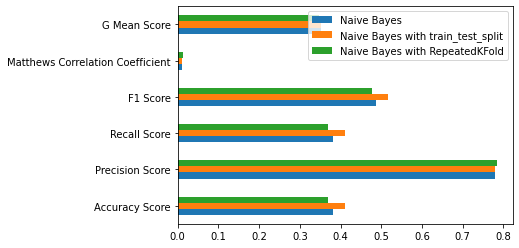

In [24]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

ax=re1.plot(kind='barh')
fig = ax.get_figure()
fig.savefig('Naive Bayes.png', bbox_inches='tight')

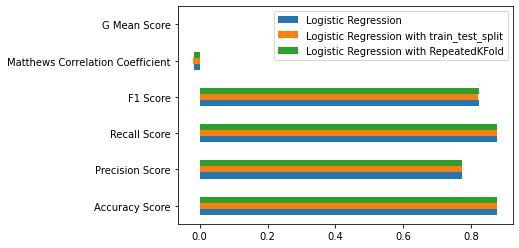

In [25]:
ax=re2.plot(kind='barh')
fig = ax.get_figure()
fig.savefig('Logistic Regression.png', bbox_inches='tight')

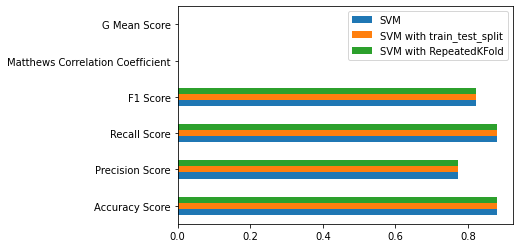

In [26]:
ax=re3.plot(kind='barh')
fig = ax.get_figure()
fig.savefig('SVM.png', bbox_inches='tight')

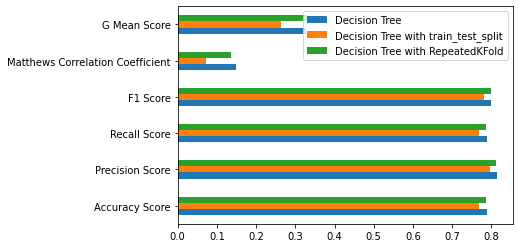

In [27]:
ax=re4.plot(kind='barh')
fig = ax.get_figure()
fig.savefig('Decision Tree', bbox_inches='tight')

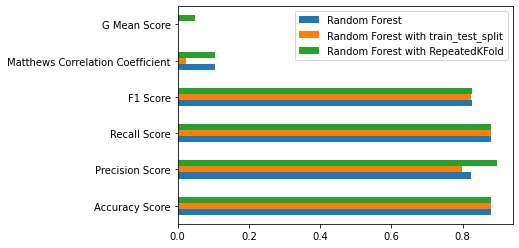

In [28]:
ax=re5.plot(kind='barh')
fig = ax.get_figure()
fig.savefig('Random Forest', bbox_inches='tight')

## Conclusion